# Measuring readability with NLP

## Lecture plan

- What is **readability**?  
- Approaches to *measuring* readability.  
   - Implementing a simple readability formula.
- Limitations and future work.

## What is readability?

> **Readability** refers to how easy, accessible, or comprehensible a text is to read.

- A children's book is typically *easy* to read.  
- *Ulysses* by James Joyce is generally considered difficult to read.
- Obviously a spectrum, and dependent on *context* and *audience*.


### Why does readability matter?

- **Education**: important for determining "grade level" of books.  
- **Accessbility**: texts should be *comprehensible* by people who need to understand them.
   - [Web content accessibility guidelines](https://en.wikipedia.org/wiki/Web_Content_Accessibility_Guidelines) discuss readability.
   - [Some product manuals](https://en.wikipedia.org/wiki/Linsear_Write) make use of readability of formulas.  
   - Probably important for legal contracts too, e.g., ["legalese"](https://www.merriam-webster.com/dictionary/legalese). 

### How can we *measure* readability?

- One approach is to *ask people*.
   - Time-consuming, hard to do for *every* text.
- Another approach is to develop **formulas** to estimate readability. 
   - E.g., number/length of words, etc.
- And yet another approach is to **build models** to estimate readability from labeled text.  

We'll be focusing on some of the *formulas*.

### Caveats: all imperfect!

- No readability formula is perfect: all make **simplifying assumptions**.  
   - E.g., assume long words are harder, etc.
- Readability probably isn't a **unitary construct**. 
   - Readability for the classoom ≠ readability for product manuals.
- But it can still be instructive to learn about how readability is estimated.

## Readability: basic approaches

> Traditional approaches to measuring readability rely on [**formulas**](https://en.wikipedia.org/wiki/Readability#Popular_Readability_Formulas).

- Incorporate basic, interpretable **features of text**.  
   - E.g., length of words, number of words, length of sentences.  
- Combine these features using **pre-defined operations**.

### Flesch-Kincaid: a classic approach

> [Flesch-Kincaid](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests) is a particularly well-known approach, which uses the total number of **syllables**, total number of **words**, and total number of **sentences** in a text.

The **grade level** of a text is measured as follows:

$0.39 * \frac{count(words)}{count(sentences)} + 11.8 * \frac{count(syllables)}{count(words)} - 15.59$

- Ratio of *words* to *sentences*: how long is average sentence?  
- Ratio of *syllables* to *words*: how long is average word?
- **Assumption**: longer sentences with longer words are *less readable*. 
- The numbers are like *coefficients* to make the output interpretable with respect to grade level.

#### Check-in: Implementing Flesch-Kincaid from scratch

Let's start by implementing the *first half* of Flesch-Kincaid:

$\frac{count(words)}{count(sentences)}$

How could we calculate the ratio of *words* to *sentences* in a text?

In [1]:
### Your code here

#### Comparing words to sentences

We can use `nltk.word_tokenize` and `nltk.sent_tokenize` here.

In [2]:
import nltk

In [5]:
def calculate_word_sentence_ratio(text):
    num_words = len(nltk.word_tokenize(text))
    num_sentences = len(nltk.sent_tokenize(text))
    return num_words/num_sentences

In [6]:
text = "It was a dark and stormy night. Everyone was all inside."
calculate_word_sentence_ratio(text)

6.5

#### Check-in: calculating syllable:word ratio

The second half of Flesch-Kincaid relies on the *syllable:word* ratio:

$\frac{count(syllables)}{count(words)}$

Here, we'll need to estimate the number of syllables. How might we do this?

In [7]:
### Your code/ideas here

#### Calculating syllables: a naive approach

- Naively, English words have *about* one vowel per syllable.  
- So we can just count the number of vowels in a word.

In [8]:
def naive_syllable_count(word):
    word = word.lower()
    syllable_count = 0
    vowels = "aeiouy"
    for i in word:
        if i in vowels:
            syllable_count += 1
    return syllable_count

In [9]:
naive_syllable_count("hello") ### works

2

In [13]:
naive_syllable_count("flies") ### hmm...

2

In [14]:
naive_syllable_count("pie") ### hmm...

2

#### Calculating syllables: a modified approach

- Some vowels don't contribute to the number of syllables in a word.  
- E.g., "e" at the end of a word typically doesn't add a syllable.

In [16]:
def modified_syllable_count(word):
    word = word.lower()
    syllable_count = 0
    vowels = "aeiouy"
    for i in word:
        if i in vowels:
            syllable_count += 1
    if word.endswith("e"): ### check for ending with "e"
        syllable_count -= 1
    return syllable_count

In [17]:
modified_syllable_count("pie") ### better!

1

In [19]:
modified_syllable_count("friendly") ### still overestimates...

3

#### Calculating syllables: a dictionary-based approach

- Ideally, we could use a **pronunciation dictionary** that tells us exactly how long each word is.  
- `nltk` has such a dictionary!

In [20]:
import nltk
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/seantrott/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [23]:
### Import cmudict
from nltk.corpus import cmudict
d = cmudict.dict()

#### The *CMU* dictionary

- The **CMU Dictionary** will `return` a representation of the *phonemes* in a word.  
  - Will also include multiple *pronunciations*.
- Each phoneme with a *digit in its last position* (e.g., `EH1`) counts as a **vowel that contributes a syllable**.

In [45]:
### Simple example
d['pie']

[['P', 'AY1']]

In [46]:
### Looking at the first pronunciation of "friendly"
d['friendly'][0]

['F', 'R', 'EH1', 'N', 'D', 'L', 'IY0']

#### Putting it altogether

- First, if word is in CMU:
   - We calculate number of syllables in *first pronunciation*.
- CMU may not have *every* word in the dictionary, so we can **fall back** on our other function.

In [62]:
def syllable_count(word):
    """
    Returns the number of syllables in a word using the CMU Pronouncing Dictionary.
    If the word isn't found, falls back to a heuristic approach.
    """
    word = word.lower()
    if word in d:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word]][0]
    else:
        # Fallback syllable counter
        return modified_syllable_count(word)

In [63]:
estimate_syllables("friendly")

2

In [64]:
estimate_syllables("mistake")

2

#### Complete Flesch-Kincaid formula

- Okay, now let's create our final Flesch-Kincaid formula.

In [65]:
def flesch_kincaid_grade_level(text):
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)
    num_sentences = len(sentences)
    num_words = len(words)
    num_syllables = sum(estimate_syllables(word) for word in words if word.isalpha())  # only count alphabetic words to avoid punctuation
    
    if num_words == 0 or num_sentences == 0:
        return 0  # Avoid division by zero
    
    grade_level = 0.39 * (num_words / num_sentences) + 11.8 * (num_syllables / num_words) - 15.59
    return grade_level

#### Testing our implementation (1)

In [94]:
sample_text1 = '"The Australian platypus is seemingly a hybrid of a mammal and reptilian creature.'
sample_text2 = "Dogs are pretty cute and also run really fast."

In [95]:
flesch_kincaid_grade_level(sample_text1)

9.140000000000004

In [96]:
flesch_kincaid_grade_level(sample_text2)

2.4700000000000024

#### Testing our implementation (2)

- The [CLEAR Corpus](https://link.springer.com/article/10.3758/s13428-022-01802-x) contains human judgments about the readability of text excerpts. 
- It also contains estimates of Flesch-Kincaid score, etc., for those excerpts.

In [107]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [98]:
df_clear = pd.read_csv("data/text/CLEAR_corpus_final.csv")
df_clear.head(2)

,ID,Author,Title,Anthology,URL,Pub Year,Categ,Sub Cat,Lexile Band,Location,...,BT_easiness,s.e.,Flesch-Reading-Ease,Flesch-Kincaid-Grade-Level,Automated Readability Index,SMOG Readability,New Dale-Chall Readability Formula,CAREC,CAREC_M,CML2RI
0,400,Carolyn Wells,Patty's Suitors,NaN,http://www.gutenberg.org/cache/epub/5631/pg563...,1914.0,Lit,NaN,900,mid,...,-0.340259,0.464009,81.70,5.95,7.37,8.0,6.55,0.12102,0.11952,12.097815
1,401,Carolyn Wells,Two Little Women on a Holiday,NaN,http://www.gutenberg.org/cache/epub/5893/pg589...,1917.0,Lit,NaN,700,mid,...,-0.315372,0.480805,80.26,4.86,4.16,7.0,6.25,0.04921,0.04921,22.550179


#### Check-in: estimate readability scores

Use `.apply` on the `Excerpt` column to estimate the Flesch-Kincaid score for each of those excerpts.

In [99]:
### Your code here

#### Using `.apply`

In [101]:
df_clear['fk_estimate'] = df_clear['Excerpt'].apply(lambda x: flesch_kincaid_grade_level(x))

#### Checking our work

- We see a pretty good correlation with the ground truth.  
- Divergences are probably due to different ways of counting punctuation, etc.

In [108]:
ss.pearsonr(df_clear['Flesch-Kincaid-Grade-Level'], df_clear['fk_estimate'])

PearsonRResult(statistic=0.9725542857996391, pvalue=0.0)

<Axes: xlabel='Flesch-Kincaid-Grade-Level', ylabel='fk_estimate'>

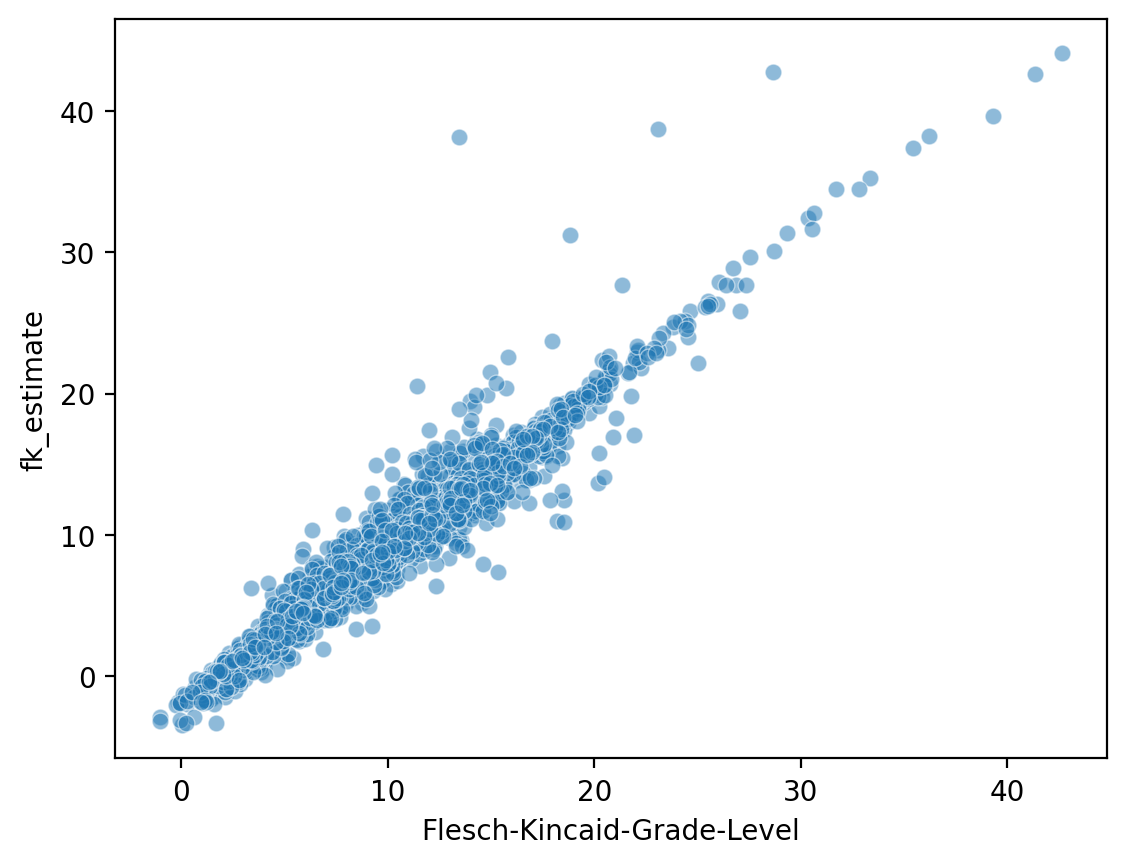

In [106]:
sns.scatterplot(data = df_clear, 
                x = "Flesch-Kincaid-Grade-Level",
               y = "fk_estimate", alpha = .5)

#### Does it predict *actual* readability?

- Correlated, but not *amazingly*, with human judgments of readability.

In [111]:
ss.pearsonr(df_clear['BT_easiness'], df_clear['fk_estimate'])

PearsonRResult(statistic=-0.4950639526178968, pvalue=1.209795142656632e-290)

<Axes: xlabel='fk_estimate', ylabel='BT_easiness'>

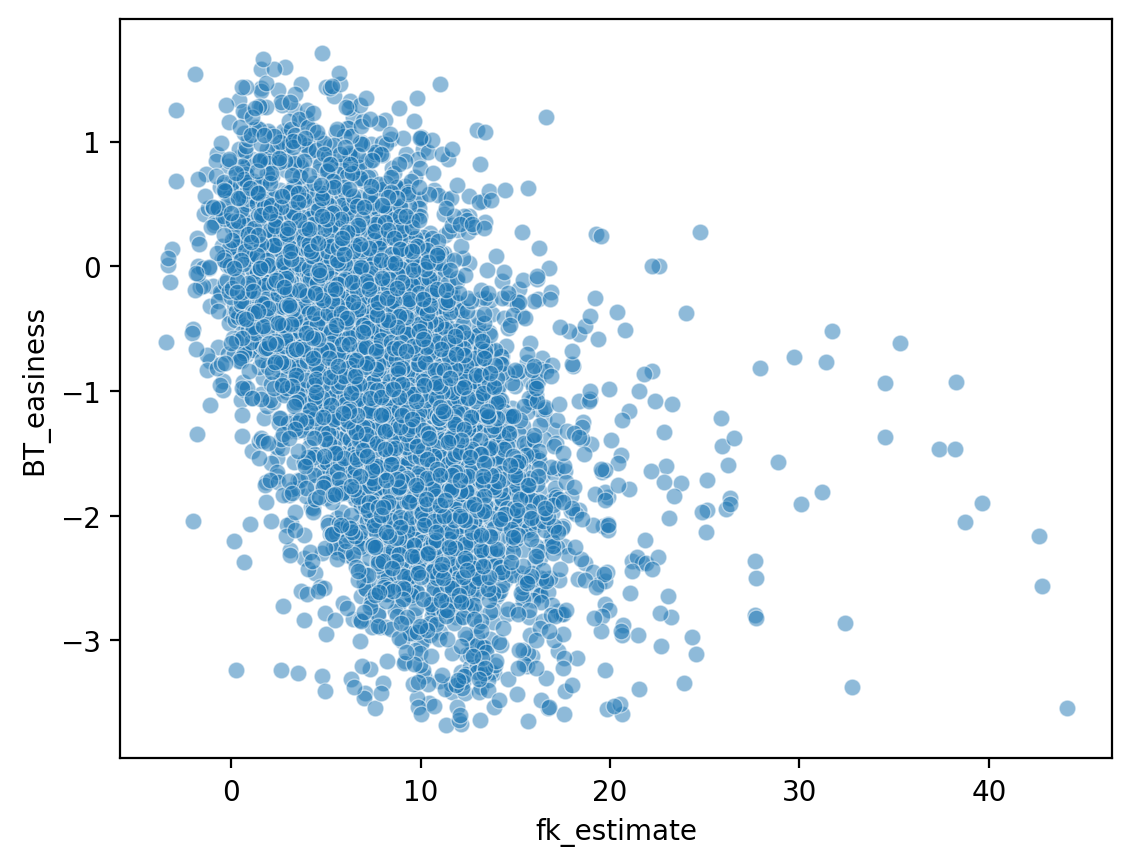

In [112]:
sns.scatterplot(data = df_clear, 
                x = "fk_estimate",
               y = "BT_easiness", alpha = .5)

### Other formulas

- Flesch-Kincaid is just *one* approach among many.  
- Other [popular formulas](https://en.wikipedia.org/wiki/Readability#Popular_Readability_Formulas) rely on similar dimensions:
   - Average sentence length.  
   - Average word length.

What else might you want to consider?

## Beyond simple formulas

- Advanced readability formulas also incorporate **psycholinguistic variables**.  
  - Frequency, concreteness, age of acquisition.
- Modern approaches also rely on **Large Language Models (LLMs)**. 
  - E.g., [my attempt with GPT-4 Turbo](https://seantrott.substack.com/p/measuring-the-readability-of-texts). 
- Remains a *complex construct*: always remember it is dependent on audience and context.